In [237]:
import pandas as pd
import sqlite3 as db
import datetime as dt
import numpy as np

from scipy import stats
from sklearn.metrics import r2_score,explained_variance_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

Identifying birds that strongly select for one or more habitats

In [71]:
github_userName = 'Tanag3r'
ebird_token = 'j6c7l80ga2ib'
db_name = 'trailheadDirectBirds_sous.db'

In [72]:
##connect to database
def connectDB():
    try:
        cnx = db.connect(db_name)
    except Exception as cnxError:
        raise UserWarning(f'Unable to connect to database due to: {cnxError}')
    return cnx

In [110]:
##TODO #99 replace the update latestUpdate in the function with a trigger in the database
class notInTable(ValueError):
    def __init__(self,locId,message="given locId cannot be found in table Hotspots"):
        self.locId = locId
        self.message = message
        super().__init__(self.message)
    def __str__(self):
        return f'{self.locId} >> {self.message}'


In [227]:
class emptyReturn(TypeError):
    
    def check_speciesCode(self,speciesCode: str,cnx):
        cursor = cnx.cursor()
        checkQuery = """SELECT EXISTS(SELECT ? FROM historicObservations WHERE speciesCode = ?);"""
        checkTuple = (speciesCode,speciesCode)
        checkResult = cursor.execute(checkQuery,checkTuple).fetchone()[0]
        if checkResult == 0:
            message = f"{speciesCode}: the given species code is not in the database"
        else:
            message = "no values have been returned by the query"
        return message
    def __init__(self,speciesCode,cnx):
        self.speciesCode = speciesCode
        self.cnx = cnx
        self.message = self.check_speciesCode(speciesCode=speciesCode,cnx=cnx)
        super().__init__(self.message)
    def __str__(self):
        return f'{self.check_speciesCode}'  

In [146]:
def post_hotspotHabitat(locId: str,label: int,cnx=connectDB()):
    try:
        cursor = cnx.cursor()
    #validate
        validate_query = "SELECT EXISTS(SELECT ? FROM Hotspots WHERE locId = ?)"
        validate_tuple = (locId,locId)
        cursor.execute(validate_query,validate_tuple)
        validate = cursor.fetchone()[0]
        if validate == 0:
            raise notInTable(locId)
        else:
            updateLabel_script = "UPDATE Hotspots SET habitatLabel = ?, latestUpdate = ? WHERE locId = ?;"
            updatelabel_tuple = (label,str(dt.datetime.today()),locId)
            cursor.execute(updateLabel_script,updatelabel_tuple)
            cnx.commit()
            cursor.close()
    except ValueError as vxf:
        raise vxf
    except Exception as ex:
        raise ex
    return locId

In [83]:
#derive habitat cluster labels from FAO values using k-means
def kmeans_habitat(distinctHabitats: int,cnx= connectDB()):
    try:
        data = pd.read_sql(sql='SELECT * FROM FAO_by_locId;',con=cnx)
        data = data.drop(columns=['locName']).set_index('locId')
        data.fillna(0,inplace=True)
    #normalize
        maxValue = data.apply(max,axis=1)
        data = data.apply(lambda x: (x/maxValue[x.index]),axis=0)   #min-max normalizing to smooth in proportionality
    #compute kmeans for each locId
        habitat_kmeans = KMeans(n_clusters=distinctHabitats,init='k-means++')
        habitat_kmeans = habitat_kmeans.fit(data.values)
        clusterLabels = habitat_kmeans.labels_
        centerPoints = habitat_kmeans.cluster_centers_
    #define habitats
        habitatFrame = pd.DataFrame(data=clusterLabels,columns=['clusterLabel'],index=data.index).sort_values(by='clusterLabel').reset_index()
        #habitatFrame = pd.merge(left=habitatFrame,left_on='locId',right=data,right_on='locId',how='left')
    except Exception as kmeansExc:
        raise kmeansExc
    return habitatFrame,centerPoints

Test and interpolate

In [122]:
##TODO #100 write a function to test for seasonal preference with a scaling lead-lag scope dependent on volume of observations available
query = f"""with habitatAbundance as (
select
	(strftime('%Y',obsDt)||'-'||strftime('%W',obsDt)) as "year_week",
	round(avg(howMany),0) as "habitatVolume",
	(total(round(avg(howMany),0)) over(partition by strftime('%Y',obsDt)||'-'||strftime('%W',obsDt))) as "volume_allHabitats",
	habitatLabel 
from historicObservations as hsob
left join (select locId,habitatLabel from Hotspots) as "labels" on hsob.locId=labels.locId
where speciesCode = '{speciesCode}'
group by year_week,habitatLabel
)
select year_week,round((habitatVolume/volume_allHabitats),2) as "selectionRatio_{i}"
from habitatAbundance
where habitatLabel = {i}
;"""

In [225]:
def build_datebase(speciesCode,con = connectDB()):
    try:
        cursor = con.cursor()
        minDateQuery = f"""select date(obsDt) as "startDate" from historicObservations group by speciesCode having obsDt=min(obsDt) and speciesCode = '{speciesCode}';"""
        maxDateQuery = f"""select date(obsDt) as "stopDate" from historicObservations group by speciesCode having obsDt=max(obsDt) and speciesCode = '{speciesCode}';"""
        validate = cursor.execute(minDateQuery).fetchone()
        if validate is None:
            raise emptyReturn(speciesCode=speciesCode,cnx=con)
        else:
            minDate = cursor.execute(minDateQuery).fetchone()[0]
            maxDate = cursor.execute(maxDateQuery).fetchone()[0]
            datebase = []
            for i in pd.date_range(start=minDate,end=maxDate,freq='D',name='dates'):
                datebase.append(i)
    except Exception as ex:
        raise ex
    return datebase

In [159]:
#todo seasonality test on compiled selection data

2.5

In [250]:
#normalize and prepare fpar, lai data
fpar_and_lai_query = """SELECT
	fpar.Date as "readingDate",
	fpar.Mean as "fparMean",
	CASE WHEN lai.Mean <= 0 THEN 0.1 ELSE lai.Mean END as "laiMean",
	fpar.locId,
	(select habitatLabel from Hotspots where Hotspots.locId=fpar.locId) as "habitatLabel"
from "MOD15A2H-006-Statistics.csv_MODIS_cooking" as fpar
left join (select * from "MOD15A2H-006-Statistics.csv_MODIS_cooking" as leafArea where leafArea.Dataset = 'Lai_500m') as lai on lai.locId = fpar.locId and lai.Date = fpar.Date
where fpar.Dataset = 'Fpar_500m'
and readingDate not like '19%'
and habitatLabel = 7
order by fpar.locId desc,readingDate asc
;"""
fparLai = pd.read_sql(sql=fpar_and_lai_query,con=connectDB(),parse_dates='readingDate')
fparLai.head()

,readingDate,fparMean,laiMean,locId,habitatLabel
0,2018-12-27,0.482,1.22,L10129014,7
1,2019-01-01,0.482,1.22,L10129014,7
2,2019-01-09,0.410,0.58,L10129014,7
3,2019-01-17,0.050,0.10,L10129014,7
4,2019-01-25,0.410,0.60,L10129014,7


In [255]:
fparLai['laiMean_powerTransform'],lbda = stats.boxcox(fparLai['laiMean'])
fparLai['fparMean_powerTransform'],lbda = stats.boxcox(fparLai['fparMean'])
fparLai.head(15)

,readingDate,fparMean,laiMean,locId,habitatLabel,laiMean_powerTransform,fparMean_powerTransform
0,2018-12-27,0.482,1.22,L10129014,7,0.206463,-0.463018
1,2019-01-01,0.482,1.22,L10129014,7,0.206463,-0.463018
2,2019-01-09,0.410,0.58,L10129014,7,-0.492626,-0.516919
3,2019-01-17,0.050,0.10,L10129014,7,-1.541356,-0.723657
4,2019-01-25,0.410,0.60,L10129014,7,-0.464820,-0.516919
5,2019-02-02,0.112,0.20,L10129014,7,-1.207888,-0.698606
6,2019-02-10,0.088,0.18,L10129014,7,-1.264334,-0.709119
7,2019-02-18,0.534,0.80,L10129014,7,-0.214050,-0.422225
8,2019-02-26,0.540,0.84,L10129014,7,-0.168768,-0.417423
9,2019-03-06,0.512,0.82,L10129014,7,-0.191237,-0.439666


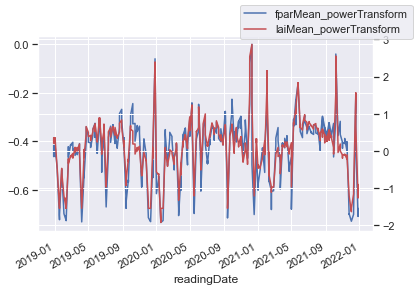

In [256]:
ax = fparLai.plot(x='readingDate',y='fparMean_powerTransform',legend=False)
ax2 = ax.twinx()
fparLai.plot(x='readingDate',y='laiMean_powerTransform',ax=ax2,legend=False,color='r')
ax.figure.legend()
plt.show()